# RQ3: Can We Find an Ideal Area For A Business to Locate?

This notebook draws a map of a city using Basemap. The example below uses "Florist" in "OH" but this can be changed using the suggestions to give any category in any of our states.

In [4]:
given_category = "Florists"   # Most popular: Restauraunts, Shopping, Food, 
                                    # Beauty & Spas, Home Services, Health & Medical, 
                                    # Nightlife, Local Services, Automotive, Bars

givenState = "OH" # AZ, NV, OH, PA, IL, NC, or WI

In [5]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.patches import Polygon
from matplotlib import colors as mcolors
from mpl_toolkits.basemap import Basemap
import math
from __future__ import division #We're using Python 2 for basemap so need to import some Python 3 math features
from pylab import *

module_path = os.path.abspath(os.path.join('../../data/..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%matplotlib inline

### Category Table
Making a table that gathers all info about a category in each postcode:
- Number of businesses of that category
- Average interactions for that category
- % of that category that's open

In [6]:
businessPrepped = pd.read_csv('../../data/analysis/businessFinal.csv')

def given_cat_open(row, given_cat):
    if ((row['is_open'] == 1) and (given_cat in row['categories'].lower())):
        return 1
    return 0

def given_cat(row, given_cat):
    if (given_cat in row['categories'].lower()):
        return 1
    return 0

def given_cat_interactions(row, given_cat):
    if (row['is_open'] == 1 and given_cat in row['categories'].lower()):
        return row['interactionsWeighted']
    return 0

businessPrepped['givenCat_and_open'] = businessPrepped.apply(lambda row : given_cat_open(row, given_category.lower()), axis=1)
businessPrepped['givenCat'] = businessPrepped.apply(lambda row :given_cat(row, given_category.lower()), axis=1)
businessPrepped['givenCat_interactions'] = businessPrepped.apply(lambda row: given_cat_interactions(row, given_category.lower()), axis = 1)


zipProfileGroups = businessPrepped.groupby(['postal_code', 'state']).agg({'business_id':'count', 'givenCat':sum,'givenCat_and_open':sum,'is_open':sum, 'givenCat_interactions':'mean', 'interactionsWeighted':'mean'})

zipProfileDf = pd.DataFrame(zipProfileGroups)
zipProfileDf.reset_index(level = 1, inplace = True)

zipProfileDf.columns = ['state','avg','num_givenCat_open','num_businesses','total_open', 'num_givenCat',\
                        'givenCat_interactions']


zipProfileDf['percent_givenCat_Open'] = (zipProfileDf['num_givenCat_open']/zipProfileDf['num_givenCat'])*100
zipProfileDf['givenCat_Proportion'] = (zipProfileDf['num_givenCat_open'] / zipProfileDf['total_open']) * 100

zipProfileDf = zipProfileDf.reset_index()

In [7]:
zipProfileDf.head()

,postal_code,state,avg,num_givenCat_open,num_businesses,total_open,num_givenCat,givenCat_interactions,percent_givenCat_Open,givenCat_Proportion
0,02224,OH,31.325797,0,1,1,0,0.0,NaN,0.0
1,05440,VT,15.589855,0,2,2,0,0.0,NaN,0.0
2,05452,PA,147.606374,0,1,1,0,0.0,NaN,0.0
3,06618,ST,20.943768,0,1,1,0,0.0,NaN,0.0
4,06632,ST,18.305829,0,9,9,0,0.0,NaN,0.0


Make this dataframe the main dataframe of the notebook.

If a category is given and there is no data, an error will be printed here.

In [8]:
df = zipProfileDf

noCat = False
if df[df['state'] == givenState]['num_givenCat'].sum() == 0:
    print("There are no businesses of type '"+given_category+"' in " + givenState)
    noCat = True

### Create City Boundaries for Each State
Each state in our dataset has one major city that the Yelp Data focuses on. I've used the co-ordinates below to zoom in on the city and outlying suburbs so each postcode can clearly be seen.

In [9]:
if givenState == 'AZ':
    city = "Phoenix" #Set city name for title of map
    az3=-112.689 # northern limit
    az4=33.1009 # western limint
    az5=-111.4146 # southern limit
    az6=33.9206 #eastern limit
    az1 = ((az6-az4)/2)+az6 # midpoint (longitude)
    az2 = ((az5-az3)/2)+az5 # midpoint (latitude)
elif givenState == 'NV':
    city = "Las Vegas"
    az3=-115.7999
    az4=35.5789
    az5=-114.2399
    az6=36.8786
    az1 = ((az6-az4)/2)+az6
    az2 = ((az5-az3)/2)+az5
elif givenState == 'OH':
    city = "Cleveland"
    az3=-82.2836
    az4=41.0371
    az5=-80.8169
    az6=41.8142
    az1 = ((az6-az4)/2)+az6
    az2 = ((az5-az3)/2)+az5
elif givenState == 'PA':
    city = "Pittsburgh"
    az3=-80.3672
    az4=40.1035
    az5=-79.4279
    az6=40.7287
    az1 = ((az6-az4)/2)+az6
    az2 = ((az5-az3)/2)+az5
elif givenState == 'IL':
    city = "Urbana"
    az3=-88.79
    az4=39.52
    az5=-87.65
    az6=40.52
    az1 = ((az6-az4)/2)+az6
    az2 = ((az5-az3)/2)+az5
elif givenState == 'NC':
    city = "Charlotte"
    az3=-81.4943
    az4=34.8034
    az5=-79.8756
    az6=35.7421
    az1 = ((az6-az4)/2)+az6
    az2 = ((az5-az3)/2)+az5
elif givenState == 'WI':
    city = "Madison"
    az3=-89.9707
    az4=42.7221
    az5=-89.024
    az6=43.4091
    az1 = ((az6-az4)/2)+az6
    az2 = ((az5-az3)/2)+az5

### Postcode Boundaries Dictionary
This dictionary contains every postcode and the coordinates of every line of it's boundary.

In [10]:
#read in dictionary file created at prep stage
file = open("../../data/prep/yelpCodes.txt", "r")
code = file.read()
file.close()

In [11]:
codes = eval(code) #converting the string to a dictionary

Get all the postcodes in the state, this list is used to calculate which lines to draw

In [12]:
#Get all the postcodes in the given state and put them in a list
place = df[df['state'] == givenState]['postal_code'].unique().tolist()

### Creating a colour gradient

createColours() takes a column of ranges (made by pd.cut later on), and assigns a colour value to it based on how high/low in the list it is. 

For example, the column may be describing closure rates in an area and the values for a postcode could be "(0-2%)", "(15-20%)", etc. "(0-2%)" will have the brightest colour and "(15-20%)" will have the darkest.


We use the rgb form "(1, 0, 0)" to make the brightest red, so to make a darker red the value "(0.2, 0, 0)" will be used.
This function divides 1 by the amount of ranges we have, then multiplies it to create a gradient.

The function returns a dictionary in the form "Range" : "color intensity". For example, "(15-20%)": "0.8"

In [13]:
def createColours(series):
    groupList = series.unique()  #Record the names of the intervals in a list
    nGroups = len(groupList) #Record how many intervals we have
    
    # Create a list of numbers to be used. It's 1 divided by how ever many groups there are, then multiplied to create the colour intensity
    colourRange = []
    for i in range(nGroups):
        sums = float(1/nGroups)*i
        colourRange.append(sums)

    # Creates a dictionary so this value can easily be accessed later. It's in the form "colDict[range] = intensity"
    colDict = {}
    for i in range(nGroups):
        colDict[groupList[i]] = colourRange[i]
        
    return colDict

### Drawing and Colouring the Postcodes

makeMapPlots() draws all the state boundaries, then assigns a colour to each postcode using the function above.

We are making 3 different maps with 3 different colours so the map type is given. 

The function returns a list of plots and colours for each postcode.

In [14]:
def makeMapPlots(mapType): #mapType will be dangerzones, gaps in the market, or competitive.
    plots = []

    for key in codes: #Go through every postcode in the master list
        if key in place: #check if its in the given city
            stateLine = eval(codes[key]) #convert string to list of coordinates

            state = [] #list to hold an individual postcode boundary
            longP = [] #lats
            latP = [] #longs

            #append each individual point to the lats and longs
            for i in stateLine:
                longP.append(i[0])
                latP.append(i[1])

            #find the current postcode in the category analysis dataframe
            if mapType == 'danger':
                gradient = produceDangerGradient(key) #these functions are unique to each type and will be explained in their section
            elif mapType == 'gap':
                gradient = produceGapGradient(key)
            elif mapType == 'comp':
                gradient = produceCompGradient(key)
            
            state = [longP, latP, gradient[0], gradient[1]] #longitude, latitude, colour, and transperency for full postcode
            plots.append(state)
    
    return plots

### Creating the Map

makeMap() uses BaseMap to draw out all our coordinates, made in the function above.

It takes in our list, the type of map it is (we have 3), and the state boundaries.

It produces a picture of the given city with all the lines and postcodes coloured according to the information for each category.

Our 3 maps are:
- "danger": Danger Zones
- "gap" : Gaps in the Market
- "comp": Competitive Areas

In [15]:
def makeMap(plotList, mapType, az1,az2,az3,az4,az5,az6):
    fig, ax = plt.subplots(figsize=(10,10))
    
    # Settings for Basemap
    service = 'ESRI_StreetMap_World_2D' #Streetmap occassionally given 'Bad Gateway Error'. Alternative: 'World_Physical_Map'
    epsg = 4269   
    xpixels = 5000

    # Set map resolution, boundarties, and projection
    m = Basemap(resolution='c', # c, l, i, h, f or None (how Crude - Fine the detail is)
                projection='mill',
                lat_0=az1, lon_0=az2,
                llcrnrlon=az3, llcrnrlat=az4, urcrnrlon=az5, urcrnrlat=az6, epsg = 4269) 

    m.arcgisimage(service=service, xpixels = xpixels, verbose= False) #Set background image
    
    #Default background if background image fails
    m.drawmapboundary(fill_color='#46bcec') 
    m.fillcontinents(color='white', zorder=0)
    
    #Draw each postcode and colour
    for i in range(len(plotList)):
        x,y = m(plotList[i][0], plotList[i][1]) # get each x and y coordinate in the list
        m.plot(x,y,color='k', zorder=10) #plot it, black line, zorder insures its above image
        xy = zip(x,y) # zip to use with basemap patches
        if mapType == "danger":
            poly = Polygon( xy, facecolor=(plotList[i][2],0,0), alpha=plotList[i][3]) #color red, alpha 0 if no data
        elif mapType == "gap":
            poly = Polygon( xy, facecolor=(0,plotList[i][2],0), alpha=plotList[i][3]) #color green, alpha 0 if no data
        elif mapType == "comp":
            poly = Polygon( xy, facecolor=(0,0,plotList[i][2]), alpha=plotList[i][3]) #color blue, alpha 0 if no data
            
        plt.gca().add_patch(poly) #draw the colour
        
    if mapType == "danger":
         plt.title(str(given_category)+" in " + str(city)+"," + givenState + ": Danger-Zones", fontsize=20) #Set title for red map
    elif mapType == "gap":
        plt.title(str(given_category)+" in " + str(city)+"," + givenState + ": Gaps in the Market", fontsize=20) #Set title for green map
    elif mapType == "comp":
        plt.title(str(given_category)+" in " + str(city)+"," + givenState + ": Competitive Areas", fontsize=20) #Set title for blue map
    
    plt.show()

### givenPlace will be the dataframe we use to calculate the points for each map

In [16]:
givenPlace = df[df['state'] == givenState].copy()

# Danger Zones
### Finding Areas of High Closure Rates
The darker the colour, the higher a danger zone it is.

In [17]:
#Find categories in given state, and find percentage open
pctClosed = givenPlace['percent_givenCat_Open']

#Split the percentages into equal groups, and make a column detailing what group the postcode belongs to
givenPlace['closeCat'] = pd.Series(pd.cut(pctClosed, 10).tolist(), index=givenPlace.index)
givenPlace = givenPlace.sort_values(by="closeCat")

givenPlace.head()

,postal_code,state,avg,num_givenCat_open,num_businesses,total_open,num_givenCat,givenCat_interactions,percent_givenCat_Open,givenCat_Proportion,closeCat
391,44223,OH,80.230565,0,124,109,1,0.000000,0.000000,0.000000,"(-0.1, 10.0]"
365,44132,OH,34.132774,0,28,20,1,0.000000,0.000000,0.000000,"(-0.1, 10.0]"
349,44116,OH,132.671032,1,244,203,2,0.053647,50.000000,0.492611,"(40.0, 50.0]"
342,44109,OH,90.291290,1,157,138,2,0.433549,50.000000,0.724638,"(40.0, 50.0]"
369,44136,OH,88.647054,2,307,270,3,0.108553,66.666667,0.740741,"(60.0, 70.0]"


- Create a colour dictionary. This calculates a number to be used in a gradient on the map.
- The more % Open, the higher the number, and therefore the colour is 'brighter'.
- Intense Colours = More Open
- So darker colours = More closure rate = "Danger-Zone"

In [18]:
colDanger = createColours(givenPlace['closeCat'])

produceDangerGradient() is used in the map function. It takes a postcode, then assigns a colour to that postcode for use on the map. If it's null (a no-data zone), the alpha is set to 0 so it has no colour.

In [19]:
def produceDangerGradient(key):
    datfr = givenPlace[givenPlace['postal_code'] == key] 
    if 'nan' not in str(datfr['closeCat'].item()): 
        col = colDanger[datfr['closeCat'].item()] #if its not null, get the colourDict value
        alph = 1 #Full visibility
    else:
        col = 0  #will make it black
        alph = 0 #will make it invisible
        
    return [col, alph]

# Gap in the Market
All the areas where none of this category have tried to set up, and there are a high level of interactions.

In [20]:
# 'gap' is our dataframe that has all the postcodes where there is none of category x
gap = givenPlace[givenPlace['num_givenCat'] == 0].copy()

#Give the avergae interactions of each of these postcodes
avgIA = gap['avg']

#Split the average interactions into groups
gap['rangeIA'] = pd.Series(pd.cut(avgIA, 10).tolist(), index=gap.index)
gap = gap.sort_values(by="avg", ascending=False)

gap.head()

,postal_code,state,avg,num_givenCat_open,num_businesses,total_open,num_givenCat,givenCat_interactions,percent_givenCat_Open,givenCat_Proportion,closeCat,rangeIA
314,44045,OH,518.555355,0,2,2,0,0.0,NaN,0.0,NaN,"(467.485, 518.555]"
410,44313,OH,285.460287,0,2,1,0,0.0,NaN,0.0,NaN,"(263.205, 314.275]"
383,44195,OH,220.826840,0,10,8,0,0.0,NaN,0.0,NaN,"(212.134, 263.205]"
416,45069,OH,211.639996,0,1,0,0,0.0,NaN,NaN,NaN,"(161.064, 212.134]"
368,44135,OH,211.217467,0,165,147,0,0.0,NaN,0.0,NaN,"(161.064, 212.134]"


In [21]:
colGap = createColours(gap['rangeIA'])

In [22]:
def produceGapGradient(key):
    datfr = gap[gap['postal_code'] == key]
    if len(datfr['rangeIA']) > 0:
        col = colGap[datfr['rangeIA'].item()]
        alph = 1
    else:
        col = 1
        alph = 0
    return [col, alph]

# Competitive Areas
Alot of the category is doing well. High % Open and high % Interactions

Brighter Colours -> More Competition

Dark Colours -> Lack of Competition, few interactions

In [23]:
compArea = givenPlace.copy()

#Combine percentage open with average interactions for the category to give an overall success score
def weightedSuccess(row):
    if math.isnan(row['percent_givenCat_Open']):
        pctOpen = 0 #NaN = 0% open
    else:
        pctOpen = row['percent_givenCat_Open']
        
    IA = row['givenCat_interactions'] #Number of interactions for the category
    weight = pctOpen + IA 
    return weight

compArea['success'] = compArea.apply(lambda row: weightedSuccess(row),axis=1)

In [24]:
successRate = compArea['success']

#Split into groups based on success rate
compArea['sRange'] = pd.Series(pd.cut(successRate, 10).tolist(), index=compArea.index)
compArea = compArea.sort_values(by="success", ascending=False)

In [25]:
#Darker the colour, the more successful it is
colComp = createColours(compArea['sRange'])

In [26]:
def produceCompGradient(key):
    datfr = compArea[compArea['postal_code'] == key]
    if len(datfr['sRange']) < 2:
        col = colComp[datfr['sRange'].item()]
        alph = 1
    else:
        col = 1
        alph = 0
    return [col, alph]

# Create all 3 Maps

C:\Users\lucyb\Anaconda3\envs\yelpMap\lib\site-packages\mpl_toolkits\basemap\__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\lucyb\Anaconda3\envs\yelpMap\lib\site-packages\mpl_toolkits\basemap\__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
C:\Users\lucyb\Anaconda3\envs\yelpMap\lib\site-packages\mpl_toolkits\basemap\__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\lucyb\Anaconda3\envs\yelpMap\lib\site-packages\mpl_toolkits\basemap\__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\lucyb\Anaconda3\envs\yelpMap\lib\site-packages\mpl_toolkits\basemap\__init__.py:3269: MatplotlibDeprecationWarning:

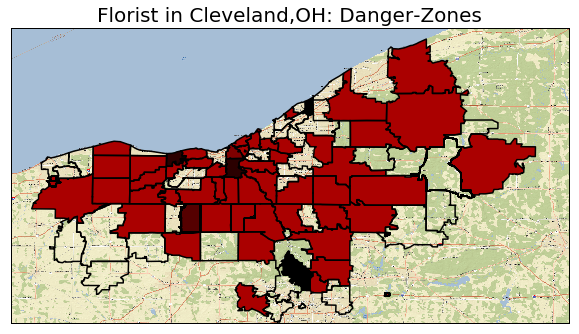

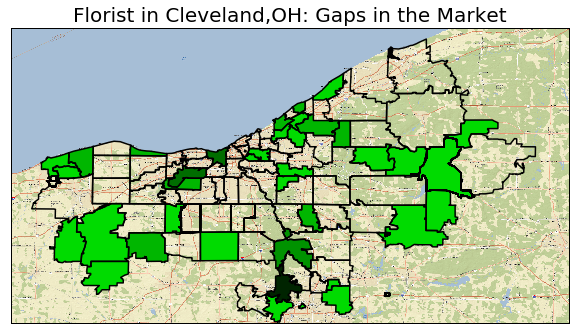

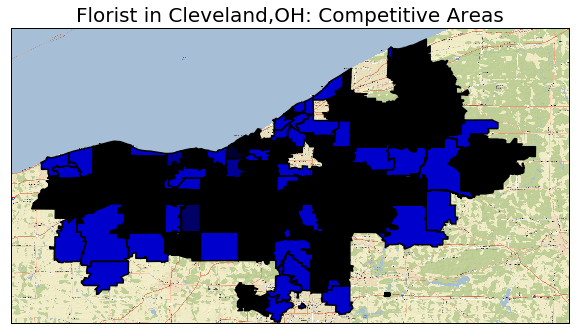

In [27]:
if noCat: # print error if there is no data avaliable to make this map
    print("There are no businesses of type '"+given_category+"' in " + givenState)
else:
    mapType = "danger"
    dangerPlots = makeMapPlots(mapType)
    makeMap(dangerPlots, mapType,az1,az2,az3,az4,az5,az6)

    mapType = "gap"
    gapPlots = makeMapPlots(mapType)
    makeMap(gapPlots, mapType,az1,az2,az3,az4,az5,az6)

    mapType = "comp"
    compPlots = makeMapPlots(mapType)
    makeMap(compPlots, mapType,az1,az2,az3,az4,az5,az6)
    